<a href="https://colab.research.google.com/github/JairLeal157/MLDiabetes/blob/main/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder



**1. Importacion de datos y exploracion basica de los datos**

importamos los datos e imprimiremos sus características junto a la forma del compartamiento de cada una de sus variables y sus correlacion


In [2]:
# Importamos los datos de csv en un dataframe de pandas
data= pd.read_csv("diabetes_prediction_dataset.csv")

# Columnas del dataframe
data.info()

# Ejemplo de los datos
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [ ]:
# definimos matriz de correlacion
corr = data.corr(method='pearson')

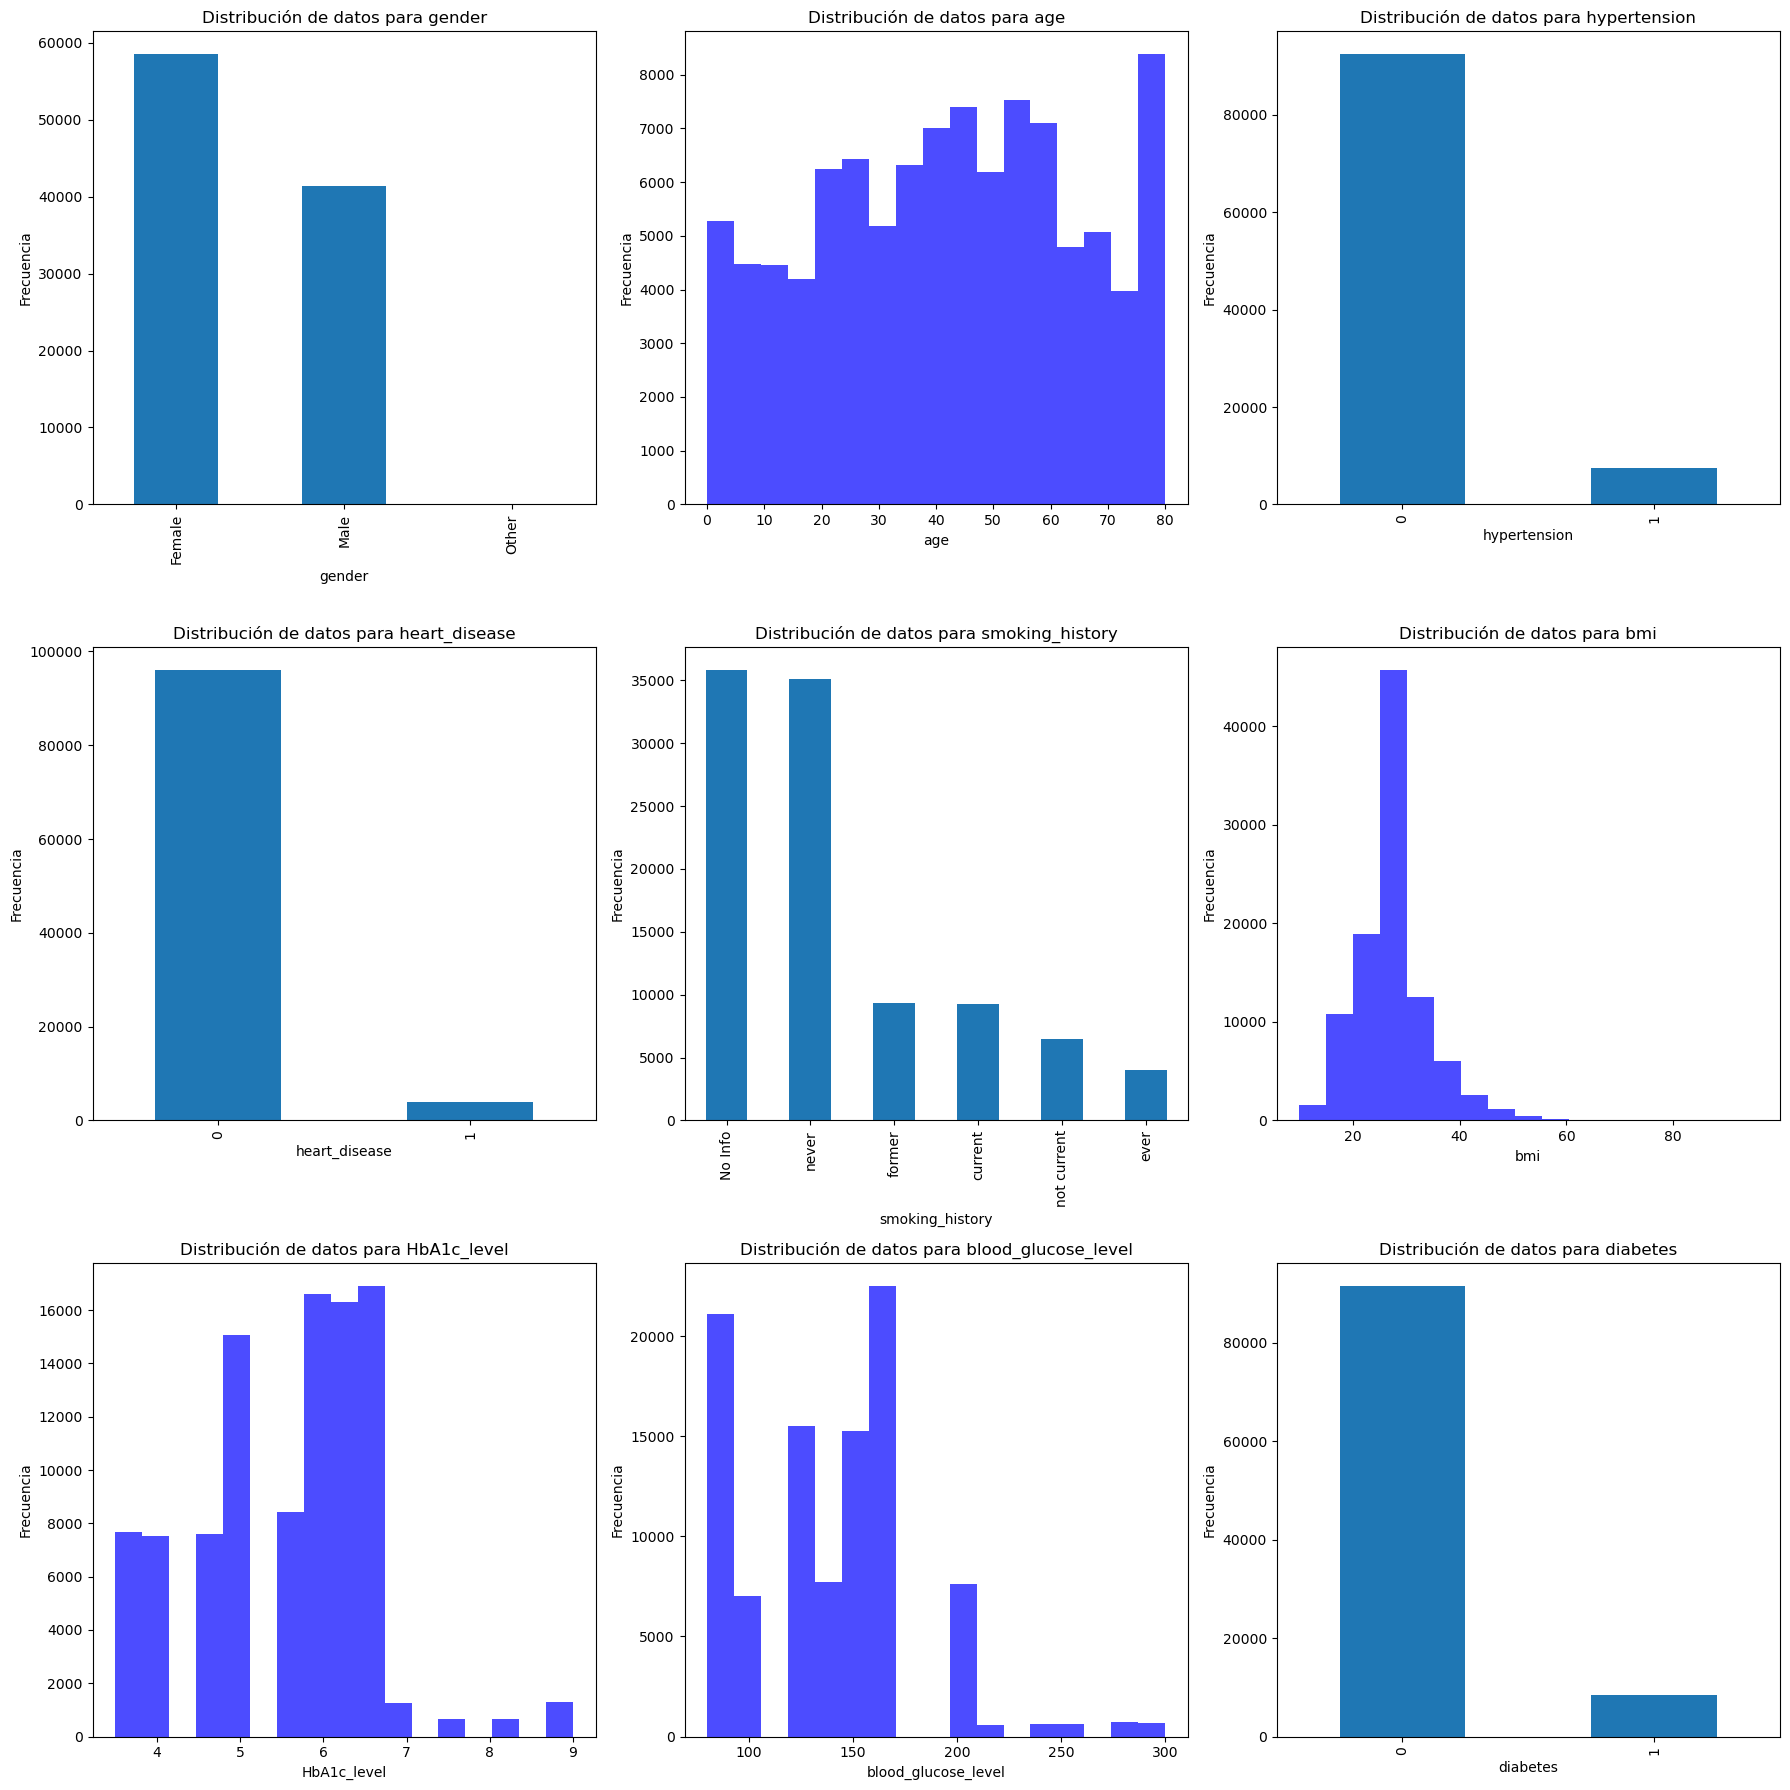

In [3]:
fig, axes = plt.subplots(3,3, figsize=(18,18))
axes = axes.ravel()
for i, columna in enumerate(data):
    ax = axes[i]
    if columna in ['gender','hypertension','heart_disease','smoking_history', 'diabetes']:
        data[columna].value_counts().plot(kind='bar', ax = ax)
    else:
        N = len(data[columna])
        num_bins = int(1 + np.log2(N))
        data[columna].plot(kind='hist', bins=num_bins, color='blue', alpha=0.7, ax = ax)

    ax.set_title(f'Distribución de datos para {columna}')
    ax.set_xlabel(columna)
    ax.set_ylabel('Frecuencia')

# Mostrar el gráfico en pantalla
plt.tight_layout()
plt.show()

**2. Tratamiento de Datos: Conversión de Datos Categóricos a Numéricos**

Convertiremos datos categóricos en representaciones numéricas para su uso en modelos de aprendizaje automático.

In [4]:
# Creamos un encoder para la columna 'gender'
gender_encoder = OneHotEncoder(sparse=False)
gender_encoded = gender_encoder.fit_transform(data[['gender']])

# Creamos un encoder para la columna 'smoking_history'
smoking_history_encoder = OneHotEncoder(sparse=False)
smoking_history_encoded = smoking_history_encoder.fit_transform(data[['smoking_history']])

# Convertimos en DataFrames
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_encoder.get_feature_names_out(['gender']))
smoking_history_encoded_df = pd.DataFrame(smoking_history_encoded, columns=smoking_history_encoder.get_feature_names_out(['smoking_history']))

# Eliminamos las columnas originales
data = data.drop(['gender', 'smoking_history'], axis=1)

# Concatenamos los DataFrames codificados 
data = pd.concat([data, gender_encoded_df, smoking_history_encoded_df], axis=1)

# Ejemplo de los datos
display(data.head())



/opt/anaconda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**3. Particion de los datos para entrenamiento**

Separaremos los datos, siendo 70% de los datos para entrenamiento y 30% para validacion.

In [6]:
# Importamos las funciones de sklearn
from sklearn.model_selection import train_test_split

# Dividimos los datos en variables de entrada y salida
X = data.drop('diabetes', axis=1)
Y = data['diabetes']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=5)


In [ ]:
# 